In [20]:
# Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from keras.utils import custom_object_scope

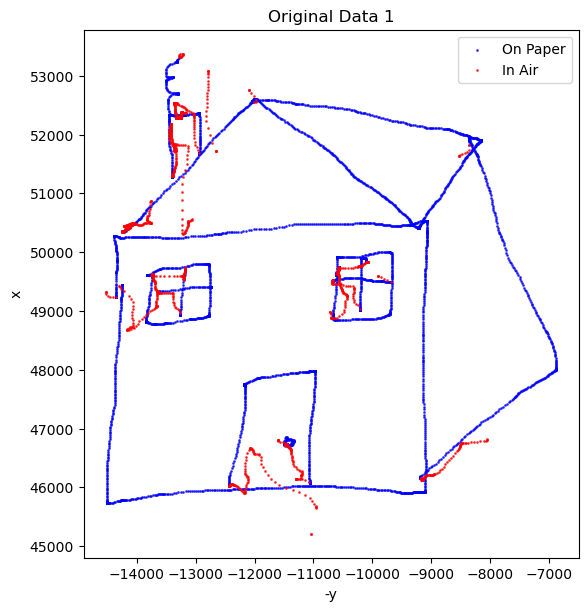

Number of processed files: 1
Average number of data points: 5553


In [61]:
# Cell 2
# Updated function
# Updated function without saving data inside
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    # If num_files_to_use is specified, only take that many files sequentially
    if num_files_to_use:
        svc_files = svc_files[:num_files_to_use]  # Take the first num_files_to_use files

    data_frames = []  # Processed data after scaling
    original_data_frames = []  # Save the original unscaled data
    scalers = []
    input_filenames = []  # List to store input filenames

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        input_filenames.append(filename)  # Store the filename
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        # Keep a copy of the original data before scaling
        original_data_frames.append(df.copy())  # Save the original unmodified data
        
        # Process the data for use in the model
        df = df.iloc[:, [0, 1, 2, 3, 4, 5, 6]] 
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

    plt.show()

    processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                      for df, scaler in zip(data_frames, scalers)]
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames  # Return original data

# Save data outside the function
def save_original_data(data_frames, input_filenames, output_folder='original_absolute'):
    os.makedirs(output_folder, exist_ok=True)
    for df, filename in zip(data_frames, input_filenames):
        save_path = os.path.join(output_folder, filename)
        df.to_csv(save_path, sep=' ', index=False, header=False)

directory = 'Task2'  # Directory where the .svc files are stored
num_files_to_use = 35
data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames = upload_and_process_files(directory, num_files_to_use)

# Save the original data after processing
save_original_data(original_data_frames, input_filenames)

# Store the name of the first file for use in Cell 4
input_filename = input_filenames[0] if input_filenames else 'processed_data'
print(f"Number of processed files: {len(processed_data)}")
print(f"Average number of data points: {avg_data_points}")


In [62]:
# Cell 6 (modified)
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(4,)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(4)
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        decoded = self.decoder(z)
        xy_timestamp = tf.sigmoid(decoded[:, :3])
        pen_status = tf.sigmoid(decoded[:, 3])
        return tf.concat([xy_timestamp, tf.expand_dims(pen_status, -1)], axis=1)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

    @classmethod
    def from_config(cls, config):
        config.pop('trainable', None)
        config.pop('dtype', None)
        return cls(**config)

    def get_config(self):
        config = super(VAE, self).get_config()
        config.update({
            'latent_dim': self.latent_dim
        })
        return config


# New: LSTM Discriminator for GAN
class LSTMDiscriminator(tf.keras.Model):
    def __init__(self):
        super(LSTMDiscriminator, self).__init__()
        self.model = Sequential()
        self.model.add(LSTM(64, return_sequences=True, input_shape=(None, 4)))  # LSTM for sequence learning
        self.model.add(LSTM(32))
        self.model.add(Dense(1, activation='sigmoid'))  # Binary classification

    def call(self, x):
        return self.model(x)


# Function to compute VAE loss
def compute_loss(model, x):
    x_reconstructed, mean, logvar = model(x)
    reconstruction_loss_xy_timestamp = tf.reduce_mean(tf.keras.losses.mse(x[:, :3], x_reconstructed[:, :3]))
    reconstruction_loss_pen = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x[:, 3], x_reconstructed[:, 3]))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return reconstruction_loss_xy_timestamp + reconstruction_loss_pen, kl_loss, kl_loss


# Parameters for VAE
latent_dim = 1024
learning_rate = 0.001

vae = VAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate)


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [63]:
# Cell 7 (modified)
def generate_augmented_data(model, num_augmented_files, avg_data_points, processed_data, base_latent_variability=1.0, latent_variability_range=(0.5, 2.0)):
    augmented_datasets = []
    num_input_files = len(processed_data)
    
    for i in range(num_augmented_files):
        selected_data = processed_data[i % num_input_files]
        original_data = data_frames[i % num_input_files]
        pressure_azimuth_altitude = original_data[['pressure', 'azimuth', 'altitude']].values
        
        latent_variability = base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1])
        
        mean, logvar = model.encode(tf.convert_to_tensor(selected_data, dtype=tf.float32))
        z = model.reparameterize(mean, logvar * latent_variability)
        
        augmented_data = model.decode(z).numpy()

        augmented_data[:, 3] = post_process_pen_status(augmented_data[:, 3])
        augmented_data[:, 2] = np.sort(augmented_data[:, 2])
        augmented_data = np.column_stack((augmented_data, pressure_azimuth_altitude[:augmented_data.shape[0]]))
        
        augmented_datasets.append(augmented_data)

    return augmented_datasets

# The post_process_pen_status function remains unchanged
def post_process_pen_status(pen_status, threshold=0.5, min_segment_length=5):
    binary_pen_status = (pen_status > threshold).astype(int)
    
    # Smooth out rapid changes
    for i in range(len(binary_pen_status) - min_segment_length):
        if np.all(binary_pen_status[i:i+min_segment_length] == binary_pen_status[i]):
            binary_pen_status[i:i+min_segment_length] = binary_pen_status[i]
    
    return binary_pen_status

c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epoch 1/100: 100%|██████████| 6/6 [00:15<00:00,  2.62s/batch, Generator Loss=0.694, Reconstruction Loss=0.694, KL Loss=0.00086] 


Epoch 1: Generator Loss = 0.878679, Reconstruction Loss = 0.878679, KL Divergence Loss = 0.000604


Epoch 2/100: 100%|██████████| 6/6 [00:00<00:00, 12.08batch/s, Generator Loss=0.602, Reconstruction Loss=0.602, KL Loss=0.00244]


Epoch 2: Generator Loss = 0.641221, Reconstruction Loss = 0.641219, KL Divergence Loss = 0.001684


Epoch 3/100: 100%|██████████| 6/6 [00:00<00:00,  7.52batch/s, Generator Loss=0.627, Reconstruction Loss=0.627, KL Loss=0.00444]


Epoch 3: Generator Loss = 0.637213, Reconstruction Loss = 0.637210, KL Divergence Loss = 0.003558


Epoch 4/100: 100%|██████████| 6/6 [00:00<00:00, 15.60batch/s, Generator Loss=0.589, Reconstruction Loss=0.589, KL Loss=0.00713]


Epoch 4: Generator Loss = 0.610416, Reconstruction Loss = 0.610410, KL Divergence Loss = 0.005773


Epoch 5/100: 100%|██████████| 6/6 [00:00<00:00, 13.48batch/s, Generator Loss=0.551, Reconstruction Loss=0.551, KL Loss=0.0144] 


Epoch 5: Generator Loss = 0.559224, Reconstruction Loss = 0.559214, KL Divergence Loss = 0.010696


Epoch 6/100: 100%|██████████| 6/6 [00:00<00:00,  9.74batch/s, Generator Loss=0.408, Reconstruction Loss=0.408, KL Loss=0.0384]


Epoch 6: Generator Loss = 0.464516, Reconstruction Loss = 0.464490, KL Divergence Loss = 0.026482


Epoch 7/100: 100%|██████████| 6/6 [00:00<00:00, 14.61batch/s, Generator Loss=0.296, Reconstruction Loss=0.296, KL Loss=0.0848]


Epoch 7: Generator Loss = 0.335003, Reconstruction Loss = 0.334938, KL Divergence Loss = 0.064464


Epoch 8/100: 100%|██████████| 6/6 [00:00<00:00, 16.57batch/s, Generator Loss=0.215, Reconstruction Loss=0.215, KL Loss=0.141] 


Epoch 8: Generator Loss = 0.249708, Reconstruction Loss = 0.249591, KL Divergence Loss = 0.117145


Epoch 9/100: 100%|██████████| 6/6 [00:00<00:00, 11.59batch/s, Generator Loss=0.156, Reconstruction Loss=0.156, KL Loss=0.184]


Epoch 9: Generator Loss = 0.188404, Reconstruction Loss = 0.188238, KL Divergence Loss = 0.166456


Epoch 10/100: 100%|██████████| 6/6 [00:00<00:00, 10.80batch/s, Generator Loss=0.0826, Reconstruction Loss=0.0823, KL Loss=0.237]


Epoch 10: Generator Loss = 0.107154, Reconstruction Loss = 0.106938, KL Divergence Loss = 0.215713


Epoch 11/100: 100%|██████████| 6/6 [00:00<00:00, 14.98batch/s, Generator Loss=0.0704, Reconstruction Loss=0.07, KL Loss=0.359]  


Epoch 11: Generator Loss = 0.074727, Reconstruction Loss = 0.074422, KL Divergence Loss = 0.305344


Epoch 12/100: 100%|██████████| 6/6 [00:00<00:00, 12.27batch/s, Generator Loss=0.0622, Reconstruction Loss=0.0617, KL Loss=0.434]


Epoch 12: Generator Loss = 0.066659, Reconstruction Loss = 0.066257, KL Divergence Loss = 0.402361


Epoch 13/100: 100%|██████████| 6/6 [00:00<00:00, 14.35batch/s, Generator Loss=0.0567, Reconstruction Loss=0.0562, KL Loss=0.519]


Epoch 13: Generator Loss = 0.060648, Reconstruction Loss = 0.060166, KL Divergence Loss = 0.481394


Epoch 14/100: 100%|██████████| 6/6 [00:00<00:00, 15.92batch/s, Generator Loss=0.0508, Reconstruction Loss=0.0501, KL Loss=0.631]


Epoch 14: Generator Loss = 0.053718, Reconstruction Loss = 0.053130, KL Divergence Loss = 0.587495


Epoch 15/100: 100%|██████████| 6/6 [00:00<00:00, 13.24batch/s, Generator Loss=0.0513, Reconstruction Loss=0.0506, KL Loss=0.698]


Epoch 15: Generator Loss = 0.052398, Reconstruction Loss = 0.051729, KL Divergence Loss = 0.668798


Epoch 16/100: 100%|██████████| 6/6 [00:00<00:00, 16.17batch/s, Generator Loss=0.048, Reconstruction Loss=0.0473, KL Loss=0.748] 


Epoch 16: Generator Loss = 0.050308, Reconstruction Loss = 0.049583, KL Divergence Loss = 0.724843


Epoch 17/100: 100%|██████████| 6/6 [00:00<00:00,  7.73batch/s, Generator Loss=0.0481, Reconstruction Loss=0.0473, KL Loss=0.761]


Epoch 17: Generator Loss = 0.048803, Reconstruction Loss = 0.048046, KL Divergence Loss = 0.756422


Epoch 18/100: 100%|██████████| 6/6 [00:00<00:00, 12.55batch/s, Generator Loss=0.0481, Reconstruction Loss=0.0474, KL Loss=0.788]


Epoch 18: Generator Loss = 0.047547, Reconstruction Loss = 0.046768, KL Divergence Loss = 0.779008


Epoch 19/100: 100%|██████████| 6/6 [00:00<00:00, 17.66batch/s, Generator Loss=0.0464, Reconstruction Loss=0.0456, KL Loss=0.807]


Epoch 19: Generator Loss = 0.046150, Reconstruction Loss = 0.045350, KL Divergence Loss = 0.799941


Epoch 20/100: 100%|██████████| 6/6 [00:00<00:00, 14.63batch/s, Generator Loss=0.0438, Reconstruction Loss=0.043, KL Loss=0.828] 


Epoch 20: Generator Loss = 0.045278, Reconstruction Loss = 0.044452, KL Divergence Loss = 0.825453


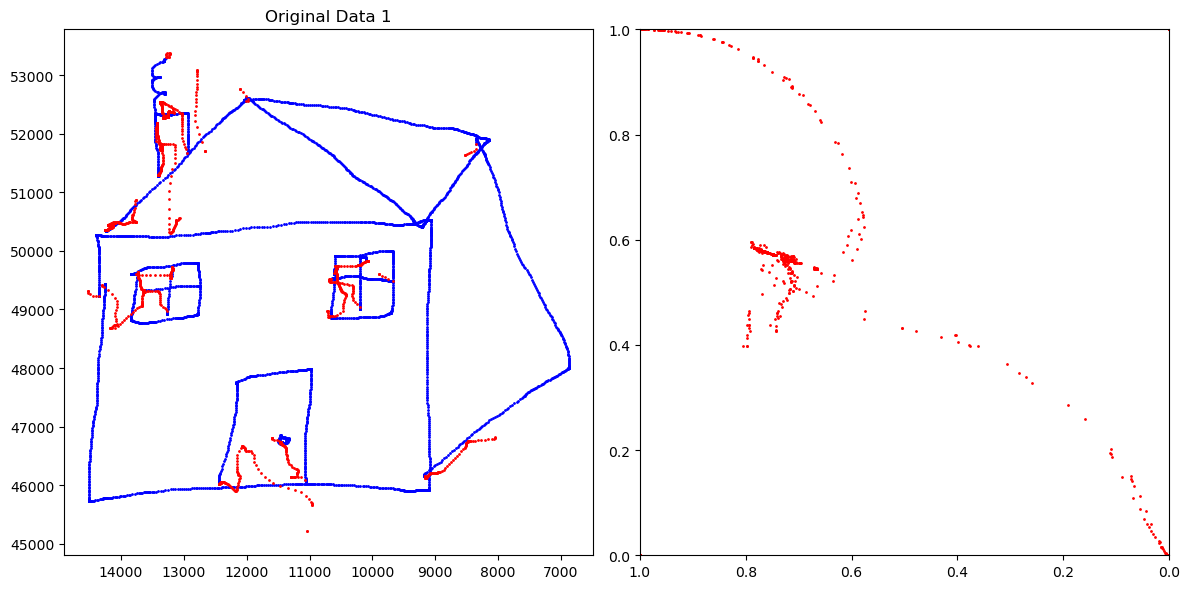

VAE model saved for epoch 20 at vae_models\epoch_20_model.h5.


Epoch 21/100: 100%|██████████| 6/6 [00:00<00:00,  6.71batch/s, Generator Loss=0.0437, Reconstruction Loss=0.0428, KL Loss=0.867]


Epoch 21: Generator Loss = 0.044054, Reconstruction Loss = 0.043198, KL Divergence Loss = 0.855956


Epoch 22/100: 100%|██████████| 6/6 [00:00<00:00, 13.70batch/s, Generator Loss=0.0429, Reconstruction Loss=0.042, KL Loss=0.905] 


Epoch 22: Generator Loss = 0.043252, Reconstruction Loss = 0.042364, KL Divergence Loss = 0.887718


Epoch 23/100: 100%|██████████| 6/6 [00:00<00:00, 14.46batch/s, Generator Loss=0.0417, Reconstruction Loss=0.0408, KL Loss=0.929]


Epoch 23: Generator Loss = 0.041710, Reconstruction Loss = 0.040787, KL Divergence Loss = 0.922913


Epoch 24/100: 100%|██████████| 6/6 [00:00<00:00, 12.85batch/s, Generator Loss=0.0405, Reconstruction Loss=0.0395, KL Loss=0.989]


Epoch 24: Generator Loss = 0.039805, Reconstruction Loss = 0.038838, KL Divergence Loss = 0.967149


Epoch 25/100: 100%|██████████| 6/6 [00:00<00:00, 16.24batch/s, Generator Loss=0.0361, Reconstruction Loss=0.0351, KL Loss=1.04] 


Epoch 25: Generator Loss = 0.038458, Reconstruction Loss = 0.037448, KL Divergence Loss = 1.010495


Epoch 26/100: 100%|██████████| 6/6 [00:00<00:00, 16.48batch/s, Generator Loss=0.0355, Reconstruction Loss=0.0344, KL Loss=1.08]


Epoch 26: Generator Loss = 0.037202, Reconstruction Loss = 0.036154, KL Divergence Loss = 1.047906


Epoch 27/100: 100%|██████████| 6/6 [00:00<00:00,  7.61batch/s, Generator Loss=0.0344, Reconstruction Loss=0.0333, KL Loss=1.12]


Epoch 27: Generator Loss = 0.035285, Reconstruction Loss = 0.034195, KL Divergence Loss = 1.089978


Epoch 28/100: 100%|██████████| 6/6 [00:00<00:00,  9.34batch/s, Generator Loss=0.0302, Reconstruction Loss=0.029, KL Loss=1.19] 


Epoch 28: Generator Loss = 0.032942, Reconstruction Loss = 0.031793, KL Divergence Loss = 1.149199


Epoch 29/100: 100%|██████████| 6/6 [00:00<00:00, 17.09batch/s, Generator Loss=0.0289, Reconstruction Loss=0.0276, KL Loss=1.23]


Epoch 29: Generator Loss = 0.030869, Reconstruction Loss = 0.029657, KL Divergence Loss = 1.211916


Epoch 30/100: 100%|██████████| 6/6 [00:00<00:00, 16.38batch/s, Generator Loss=0.0283, Reconstruction Loss=0.027, KL Loss=1.29] 


Epoch 30: Generator Loss = 0.028745, Reconstruction Loss = 0.027474, KL Divergence Loss = 1.271676


Epoch 31/100: 100%|██████████| 6/6 [00:00<00:00, 15.58batch/s, Generator Loss=0.0259, Reconstruction Loss=0.0245, KL Loss=1.35]


Epoch 31: Generator Loss = 0.026676, Reconstruction Loss = 0.025344, KL Divergence Loss = 1.332336


Epoch 32/100: 100%|██████████| 6/6 [00:00<00:00, 16.04batch/s, Generator Loss=0.0239, Reconstruction Loss=0.0225, KL Loss=1.45]


Epoch 32: Generator Loss = 0.025304, Reconstruction Loss = 0.023901, KL Divergence Loss = 1.402691


Epoch 33/100: 100%|██████████| 6/6 [00:00<00:00, 16.66batch/s, Generator Loss=0.0242, Reconstruction Loss=0.0228, KL Loss=1.47]


Epoch 33: Generator Loss = 0.023640, Reconstruction Loss = 0.022183, KL Divergence Loss = 1.457131


Epoch 34/100: 100%|██████████| 6/6 [00:00<00:00,  7.61batch/s, Generator Loss=0.0216, Reconstruction Loss=0.02, KL Loss=1.51]  


Epoch 34: Generator Loss = 0.021751, Reconstruction Loss = 0.020248, KL Divergence Loss = 1.502987


Epoch 35/100: 100%|██████████| 6/6 [00:00<00:00, 15.31batch/s, Generator Loss=0.0172, Reconstruction Loss=0.0156, KL Loss=1.56]


Epoch 35: Generator Loss = 0.018480, Reconstruction Loss = 0.016937, KL Divergence Loss = 1.542687


Epoch 36/100: 100%|██████████| 6/6 [00:00<00:00, 15.93batch/s, Generator Loss=0.0145, Reconstruction Loss=0.0129, KL Loss=1.61]


Epoch 36: Generator Loss = 0.015695, Reconstruction Loss = 0.014110, KL Divergence Loss = 1.585091


Epoch 37/100: 100%|██████████| 6/6 [00:00<00:00, 15.63batch/s, Generator Loss=0.0126, Reconstruction Loss=0.0109, KL Loss=1.65]


Epoch 37: Generator Loss = 0.013173, Reconstruction Loss = 0.011541, KL Divergence Loss = 1.632106


Epoch 38/100: 100%|██████████| 6/6 [00:00<00:00, 15.71batch/s, Generator Loss=0.0116, Reconstruction Loss=0.00983, KL Loss=1.72]


Epoch 38: Generator Loss = 0.011783, Reconstruction Loss = 0.010089, KL Divergence Loss = 1.693794


Epoch 39/100: 100%|██████████| 6/6 [00:00<00:00, 14.68batch/s, Generator Loss=0.0113, Reconstruction Loss=0.0096, KL Loss=1.72] 


Epoch 39: Generator Loss = 0.011129, Reconstruction Loss = 0.009391, KL Divergence Loss = 1.738251


Epoch 40/100: 100%|██████████| 6/6 [00:00<00:00,  8.35batch/s, Generator Loss=0.0111, Reconstruction Loss=0.0093, KL Loss=1.78] 


Epoch 40: Generator Loss = 0.010623, Reconstruction Loss = 0.008845, KL Divergence Loss = 1.777794


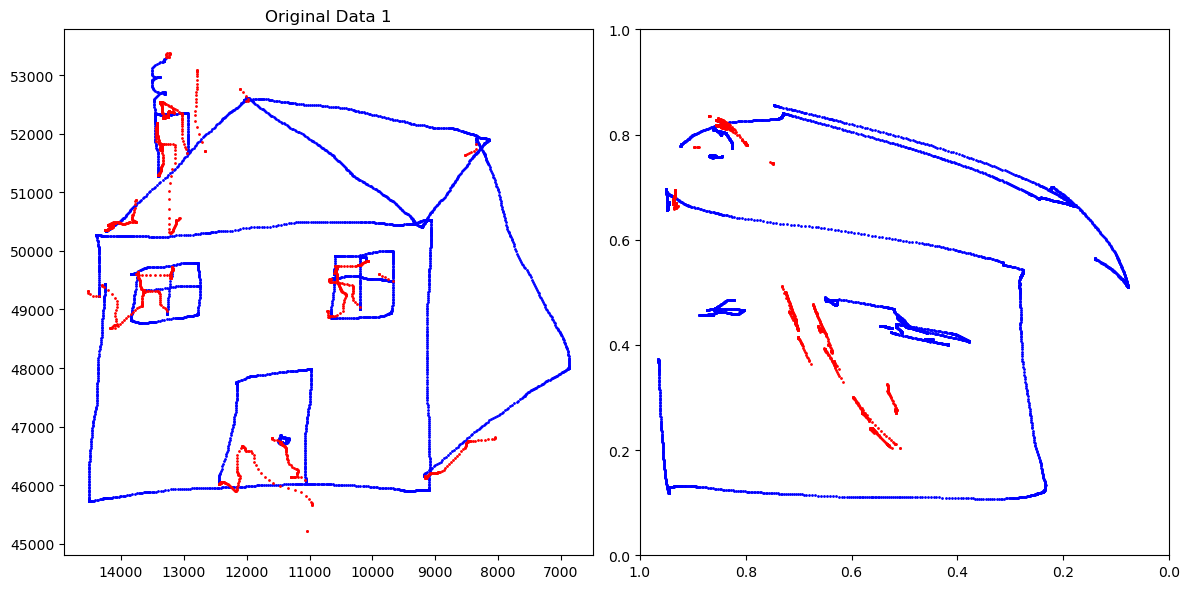

VAE model saved for epoch 40 at vae_models\epoch_40_model.h5.


Epoch 41/100: 100%|██████████| 6/6 [00:00<00:00, 14.43batch/s, Generator Loss=0.0103, Reconstruction Loss=0.00854, KL Loss=1.8] 


Epoch 41: Generator Loss = 0.010239, Reconstruction Loss = 0.008445, KL Divergence Loss = 1.794681


Epoch 42/100: 100%|██████████| 6/6 [00:00<00:00, 14.85batch/s, Generator Loss=0.00878, Reconstruction Loss=0.00698, KL Loss=1.8] 


Epoch 42: Generator Loss = 0.009918, Reconstruction Loss = 0.008116, KL Divergence Loss = 1.801945


Epoch 43/100: 100%|██████████| 6/6 [00:00<00:00, 11.52batch/s, Generator Loss=0.0097, Reconstruction Loss=0.00786, KL Loss=1.83] 


Epoch 43: Generator Loss = 0.009635, Reconstruction Loss = 0.007816, KL Divergence Loss = 1.819184


Epoch 44/100: 100%|██████████| 6/6 [00:00<00:00, 11.28batch/s, Generator Loss=0.00873, Reconstruction Loss=0.00689, KL Loss=1.83]


Epoch 44: Generator Loss = 0.009255, Reconstruction Loss = 0.007423, KL Divergence Loss = 1.831869


Epoch 45/100: 100%|██████████| 6/6 [00:00<00:00,  6.98batch/s, Generator Loss=0.00827, Reconstruction Loss=0.00645, KL Loss=1.83]


Epoch 45: Generator Loss = 0.008961, Reconstruction Loss = 0.007125, KL Divergence Loss = 1.835629


Epoch 46/100: 100%|██████████| 6/6 [00:00<00:00, 14.34batch/s, Generator Loss=0.0093, Reconstruction Loss=0.00748, KL Loss=1.81] 


Epoch 46: Generator Loss = 0.008887, Reconstruction Loss = 0.007052, KL Divergence Loss = 1.835314


Epoch 47/100: 100%|██████████| 6/6 [00:00<00:00, 10.63batch/s, Generator Loss=0.0081, Reconstruction Loss=0.00624, KL Loss=1.85] 


Epoch 47: Generator Loss = 0.008540, Reconstruction Loss = 0.006695, KL Divergence Loss = 1.845277


Epoch 48/100: 100%|██████████| 6/6 [00:00<00:00, 10.20batch/s, Generator Loss=0.00862, Reconstruction Loss=0.00679, KL Loss=1.82]


Epoch 48: Generator Loss = 0.008393, Reconstruction Loss = 0.006546, KL Divergence Loss = 1.846934


Epoch 49/100: 100%|██████████| 6/6 [00:00<00:00, 11.90batch/s, Generator Loss=0.00832, Reconstruction Loss=0.00648, KL Loss=1.84]


Epoch 49: Generator Loss = 0.008269, Reconstruction Loss = 0.006421, KL Divergence Loss = 1.848065


Epoch 50/100: 100%|██████████| 6/6 [00:00<00:00, 14.21batch/s, Generator Loss=0.00764, Reconstruction Loss=0.00578, KL Loss=1.86]


Epoch 50: Generator Loss = 0.008064, Reconstruction Loss = 0.006214, KL Divergence Loss = 1.850737


Epoch 51/100: 100%|██████████| 6/6 [00:00<00:00,  7.99batch/s, Generator Loss=0.007, Reconstruction Loss=0.00518, KL Loss=1.82]  


Epoch 51: Generator Loss = 0.007792, Reconstruction Loss = 0.005949, KL Divergence Loss = 1.842922


Epoch 52/100: 100%|██████████| 6/6 [00:00<00:00, 11.52batch/s, Generator Loss=0.00797, Reconstruction Loss=0.00613, KL Loss=1.83]


Epoch 52: Generator Loss = 0.007578, Reconstruction Loss = 0.005738, KL Divergence Loss = 1.839663


Epoch 53/100: 100%|██████████| 6/6 [00:00<00:00, 14.08batch/s, Generator Loss=0.00765, Reconstruction Loss=0.00583, KL Loss=1.82]


Epoch 53: Generator Loss = 0.007473, Reconstruction Loss = 0.005647, KL Divergence Loss = 1.826190


Epoch 54/100: 100%|██████████| 6/6 [00:00<00:00, 12.37batch/s, Generator Loss=0.00707, Reconstruction Loss=0.00526, KL Loss=1.81]


Epoch 54: Generator Loss = 0.007253, Reconstruction Loss = 0.005434, KL Divergence Loss = 1.819444


Epoch 55/100: 100%|██████████| 6/6 [00:00<00:00, 12.60batch/s, Generator Loss=0.00718, Reconstruction Loss=0.00541, KL Loss=1.77]


Epoch 55: Generator Loss = 0.007171, Reconstruction Loss = 0.005364, KL Divergence Loss = 1.807150


Epoch 56/100: 100%|██████████| 6/6 [00:00<00:00, 11.54batch/s, Generator Loss=0.00663, Reconstruction Loss=0.00482, KL Loss=1.81]


Epoch 56: Generator Loss = 0.006970, Reconstruction Loss = 0.005171, KL Divergence Loss = 1.799123


Epoch 57/100: 100%|██████████| 6/6 [00:00<00:00, 13.57batch/s, Generator Loss=0.0073, Reconstruction Loss=0.00555, KL Loss=1.75] 


Epoch 57: Generator Loss = 0.006988, Reconstruction Loss = 0.005201, KL Divergence Loss = 1.787299


Epoch 58/100: 100%|██████████| 6/6 [00:00<00:00,  7.47batch/s, Generator Loss=0.00719, Reconstruction Loss=0.00541, KL Loss=1.79]


Epoch 58: Generator Loss = 0.006717, Reconstruction Loss = 0.004936, KL Divergence Loss = 1.780740


Epoch 59/100: 100%|██████████| 6/6 [00:00<00:00, 14.22batch/s, Generator Loss=0.00675, Reconstruction Loss=0.00498, KL Loss=1.77]


Epoch 59: Generator Loss = 0.006591, Reconstruction Loss = 0.004816, KL Divergence Loss = 1.775128


Epoch 60/100: 100%|██████████| 6/6 [00:00<00:00,  8.80batch/s, Generator Loss=0.00673, Reconstruction Loss=0.00499, KL Loss=1.74]


Epoch 60: Generator Loss = 0.006478, Reconstruction Loss = 0.004711, KL Divergence Loss = 1.767339


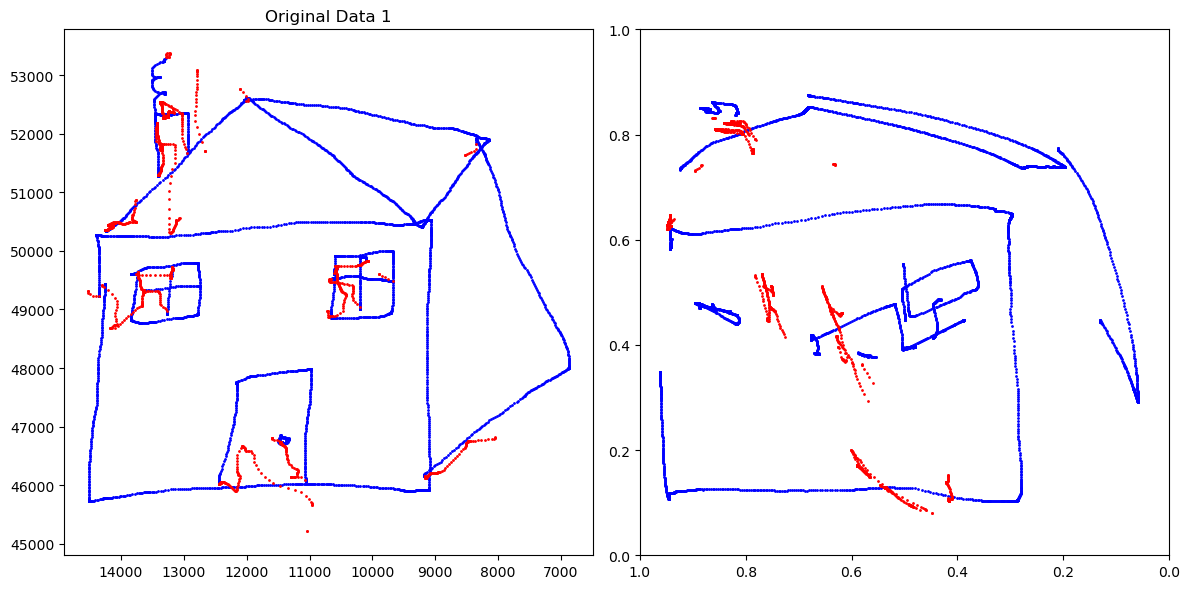

VAE model saved for epoch 60 at vae_models\epoch_60_model.h5.


Epoch 61/100: 100%|██████████| 6/6 [00:00<00:00,  7.55batch/s, Generator Loss=0.00569, Reconstruction Loss=0.00398, KL Loss=1.71]


Epoch 61: Generator Loss = 0.006271, Reconstruction Loss = 0.004516, KL Divergence Loss = 1.755357


Epoch 62/100: 100%|██████████| 6/6 [00:00<00:00, 11.43batch/s, Generator Loss=0.00575, Reconstruction Loss=0.00398, KL Loss=1.77]


Epoch 62: Generator Loss = 0.006163, Reconstruction Loss = 0.004412, KL Divergence Loss = 1.751362


Epoch 63/100: 100%|██████████| 6/6 [00:00<00:00,  8.57batch/s, Generator Loss=0.00623, Reconstruction Loss=0.00451, KL Loss=1.72]


Epoch 63: Generator Loss = 0.006112, Reconstruction Loss = 0.004374, KL Divergence Loss = 1.737368


Epoch 64/100: 100%|██████████| 6/6 [00:00<00:00, 11.06batch/s, Generator Loss=0.00558, Reconstruction Loss=0.00385, KL Loss=1.73]


Epoch 64: Generator Loss = 0.005827, Reconstruction Loss = 0.004093, KL Divergence Loss = 1.733926


Epoch 65/100: 100%|██████████| 6/6 [00:00<00:00, 15.25batch/s, Generator Loss=0.00563, Reconstruction Loss=0.0039, KL Loss=1.73] 


Epoch 65: Generator Loss = 0.005810, Reconstruction Loss = 0.004082, KL Divergence Loss = 1.728005


Epoch 66/100: 100%|██████████| 6/6 [00:00<00:00, 12.71batch/s, Generator Loss=0.00536, Reconstruction Loss=0.00361, KL Loss=1.74]


Epoch 66: Generator Loss = 0.005609, Reconstruction Loss = 0.003884, KL Divergence Loss = 1.724638


Epoch 67/100: 100%|██████████| 6/6 [00:00<00:00, 12.70batch/s, Generator Loss=0.00549, Reconstruction Loss=0.00377, KL Loss=1.72]


Epoch 67: Generator Loss = 0.005552, Reconstruction Loss = 0.003834, KL Divergence Loss = 1.717746


Epoch 68/100: 100%|██████████| 6/6 [00:00<00:00,  7.39batch/s, Generator Loss=0.00556, Reconstruction Loss=0.00385, KL Loss=1.72]


Epoch 68: Generator Loss = 0.005420, Reconstruction Loss = 0.003703, KL Divergence Loss = 1.716991


Epoch 69/100: 100%|██████████| 6/6 [00:00<00:00, 11.68batch/s, Generator Loss=0.00514, Reconstruction Loss=0.00342, KL Loss=1.72]


Epoch 69: Generator Loss = 0.005324, Reconstruction Loss = 0.003611, KL Divergence Loss = 1.713013


Epoch 70/100: 100%|██████████| 6/6 [00:00<00:00, 11.22batch/s, Generator Loss=0.00548, Reconstruction Loss=0.00376, KL Loss=1.72]


Epoch 70: Generator Loss = 0.005301, Reconstruction Loss = 0.003592, KL Divergence Loss = 1.709483


Epoch 71/100: 100%|██████████| 6/6 [00:33<00:00,  5.57s/batch, Generator Loss=0.145, Reconstruction Loss=0.00365, KL Loss=1.71]


LSTM training at epoch 71: Discriminator Loss = [1.363515]
Epoch 71: Generator Loss = 0.144263, Reconstruction Loss = 0.003467, KL Divergence Loss = 1.704650


Epoch 72/100: 100%|██████████| 6/6 [00:00<00:00, 10.54batch/s, Generator Loss=0.00541, Reconstruction Loss=0.00371, KL Loss=1.7] 


Epoch 72: Generator Loss = 0.005043, Reconstruction Loss = 0.003339, KL Divergence Loss = 1.703991


Epoch 73/100: 100%|██████████| 6/6 [00:00<00:00, 14.49batch/s, Generator Loss=0.00493, Reconstruction Loss=0.0032, KL Loss=1.73] 


Epoch 73: Generator Loss = 0.004857, Reconstruction Loss = 0.003155, KL Divergence Loss = 1.701450


Epoch 74/100: 100%|██████████| 6/6 [00:01<00:00,  4.61batch/s, Generator Loss=0.00486, Reconstruction Loss=0.00316, KL Loss=1.71]


Epoch 74: Generator Loss = 0.004746, Reconstruction Loss = 0.003046, KL Divergence Loss = 1.699389


Epoch 75/100: 100%|██████████| 6/6 [00:00<00:00,  6.97batch/s, Generator Loss=0.00469, Reconstruction Loss=0.00296, KL Loss=1.72]


Epoch 75: Generator Loss = 0.004685, Reconstruction Loss = 0.002989, KL Divergence Loss = 1.696621


Epoch 76/100: 100%|██████████| 6/6 [00:00<00:00,  9.80batch/s, Generator Loss=0.00461, Reconstruction Loss=0.00292, KL Loss=1.69]


Epoch 76: Generator Loss = 0.004612, Reconstruction Loss = 0.002920, KL Divergence Loss = 1.691316


Epoch 77/100: 100%|██████████| 6/6 [00:00<00:00, 15.91batch/s, Generator Loss=0.00475, Reconstruction Loss=0.00307, KL Loss=1.68]


Epoch 77: Generator Loss = 0.004565, Reconstruction Loss = 0.002873, KL Divergence Loss = 1.691917


Epoch 78/100: 100%|██████████| 6/6 [00:00<00:00, 13.16batch/s, Generator Loss=0.00438, Reconstruction Loss=0.00267, KL Loss=1.71]


Epoch 78: Generator Loss = 0.004514, Reconstruction Loss = 0.002825, KL Divergence Loss = 1.688773


Epoch 79/100: 100%|██████████| 6/6 [00:02<00:00,  2.40batch/s, Generator Loss=0.00452, Reconstruction Loss=0.00286, KL Loss=1.66]


Epoch 79: Generator Loss = 0.004452, Reconstruction Loss = 0.002770, KL Divergence Loss = 1.681720


Epoch 80/100: 100%|██████████| 6/6 [00:00<00:00,  8.24batch/s, Generator Loss=0.00437, Reconstruction Loss=0.00271, KL Loss=1.66]


Epoch 80: Generator Loss = 0.004416, Reconstruction Loss = 0.002740, KL Divergence Loss = 1.676520


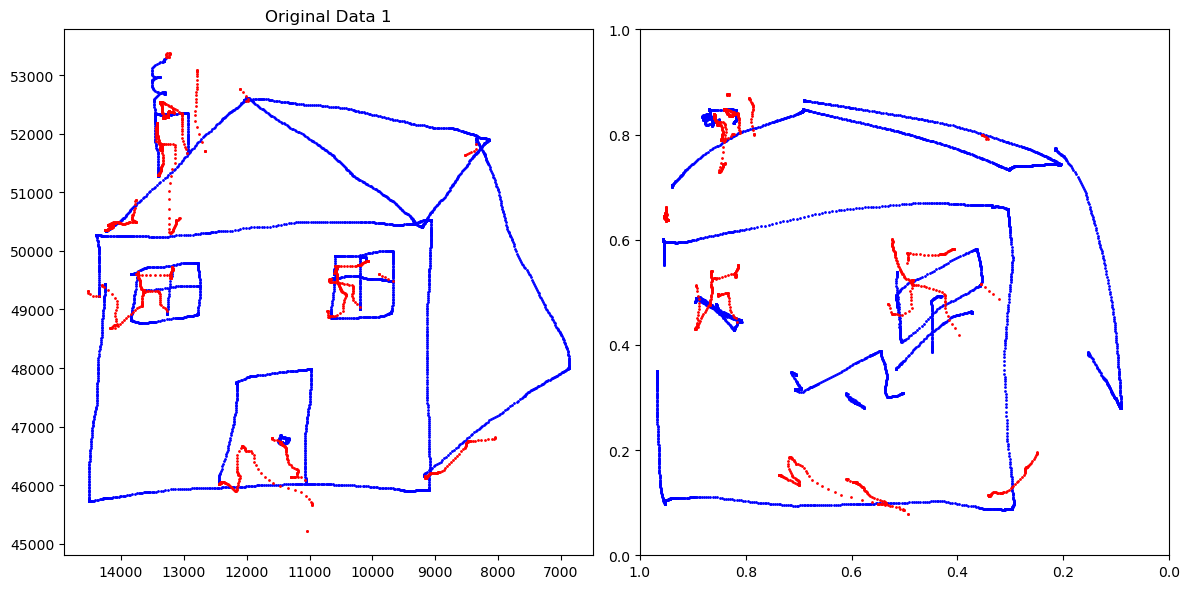

VAE model saved for epoch 80 at vae_models\epoch_80_model.h5.


Epoch 81/100: 100%|██████████| 6/6 [00:10<00:00,  1.73s/batch, Generator Loss=0.144, Reconstruction Loss=0.00271, KL Loss=1.67]


LSTM training at epoch 81: Discriminator Loss = [1.3326445]
Epoch 81: Generator Loss = 0.143998, Reconstruction Loss = 0.002714, KL Divergence Loss = 1.669061


Epoch 82/100: 100%|██████████| 6/6 [00:00<00:00, 17.23batch/s, Generator Loss=0.00444, Reconstruction Loss=0.00279, KL Loss=1.64]


Epoch 82: Generator Loss = 0.004370, Reconstruction Loss = 0.002711, KL Divergence Loss = 1.658841


Epoch 83/100: 100%|██████████| 6/6 [00:00<00:00, 13.27batch/s, Generator Loss=0.00417, Reconstruction Loss=0.00255, KL Loss=1.62]


Epoch 83: Generator Loss = 0.004230, Reconstruction Loss = 0.002577, KL Divergence Loss = 1.652499


Epoch 84/100: 100%|██████████| 6/6 [00:00<00:00,  8.34batch/s, Generator Loss=0.00409, Reconstruction Loss=0.00245, KL Loss=1.64]


Epoch 84: Generator Loss = 0.004206, Reconstruction Loss = 0.002557, KL Divergence Loss = 1.649598


Epoch 85/100: 100%|██████████| 6/6 [00:00<00:00,  9.78batch/s, Generator Loss=0.00436, Reconstruction Loss=0.0027, KL Loss=1.66] 


Epoch 85: Generator Loss = 0.004166, Reconstruction Loss = 0.002519, KL Divergence Loss = 1.647561


Epoch 86/100: 100%|██████████| 6/6 [00:00<00:00, 17.49batch/s, Generator Loss=0.00423, Reconstruction Loss=0.00257, KL Loss=1.66]


Epoch 86: Generator Loss = 0.004198, Reconstruction Loss = 0.002557, KL Divergence Loss = 1.640819


Epoch 87/100: 100%|██████████| 6/6 [00:00<00:00, 16.65batch/s, Generator Loss=0.00423, Reconstruction Loss=0.00258, KL Loss=1.65]


Epoch 87: Generator Loss = 0.004120, Reconstruction Loss = 0.002486, KL Divergence Loss = 1.633430


Epoch 88/100: 100%|██████████| 6/6 [00:00<00:00, 13.01batch/s, Generator Loss=0.00433, Reconstruction Loss=0.00274, KL Loss=1.58]


Epoch 88: Generator Loss = 0.004083, Reconstruction Loss = 0.002463, KL Divergence Loss = 1.620236


Epoch 89/100: 100%|██████████| 6/6 [00:00<00:00, 13.94batch/s, Generator Loss=0.004, Reconstruction Loss=0.00235, KL Loss=1.65]  


Epoch 89: Generator Loss = 0.004076, Reconstruction Loss = 0.002455, KL Divergence Loss = 1.620360


Epoch 90/100: 100%|██████████| 6/6 [00:00<00:00, 14.65batch/s, Generator Loss=0.00383, Reconstruction Loss=0.00222, KL Loss=1.62]


Epoch 90: Generator Loss = 0.004020, Reconstruction Loss = 0.002408, KL Divergence Loss = 1.612542


Epoch 91/100: 100%|██████████| 6/6 [00:09<00:00,  1.56s/batch, Generator Loss=0.145, Reconstruction Loss=0.00303, KL Loss=1.62]


LSTM training at epoch 91: Discriminator Loss = [1.3163937]
Epoch 91: Generator Loss = 0.144775, Reconstruction Loss = 0.002680, KL Divergence Loss = 1.610941


Epoch 92/100: 100%|██████████| 6/6 [00:00<00:00, 17.67batch/s, Generator Loss=0.00424, Reconstruction Loss=0.00269, KL Loss=1.55]


Epoch 92: Generator Loss = 0.004249, Reconstruction Loss = 0.002654, KL Divergence Loss = 1.595330


Epoch 93/100: 100%|██████████| 6/6 [00:00<00:00, 15.30batch/s, Generator Loss=0.00389, Reconstruction Loss=0.00231, KL Loss=1.59]


Epoch 93: Generator Loss = 0.004092, Reconstruction Loss = 0.002502, KL Divergence Loss = 1.589856


Epoch 94/100: 100%|██████████| 6/6 [00:00<00:00, 16.62batch/s, Generator Loss=0.00383, Reconstruction Loss=0.00225, KL Loss=1.58]


Epoch 94: Generator Loss = 0.003931, Reconstruction Loss = 0.002350, KL Divergence Loss = 1.581263


Epoch 95/100: 100%|██████████| 6/6 [00:00<00:00, 16.26batch/s, Generator Loss=0.00391, Reconstruction Loss=0.00236, KL Loss=1.56]


Epoch 95: Generator Loss = 0.003925, Reconstruction Loss = 0.002351, KL Divergence Loss = 1.573654


Epoch 96/100: 100%|██████████| 6/6 [00:00<00:00, 14.68batch/s, Generator Loss=0.00379, Reconstruction Loss=0.00223, KL Loss=1.56]


Epoch 96: Generator Loss = 0.003875, Reconstruction Loss = 0.002306, KL Divergence Loss = 1.568461


Epoch 97/100: 100%|██████████| 6/6 [00:00<00:00, 17.28batch/s, Generator Loss=0.0038, Reconstruction Loss=0.00225, KL Loss=1.55] 


Epoch 97: Generator Loss = 0.003790, Reconstruction Loss = 0.002227, KL Divergence Loss = 1.563086


Epoch 98/100: 100%|██████████| 6/6 [00:00<00:00,  8.60batch/s, Generator Loss=0.0037, Reconstruction Loss=0.00216, KL Loss=1.54] 


Epoch 98: Generator Loss = 0.003764, Reconstruction Loss = 0.002207, KL Divergence Loss = 1.556693


Epoch 99/100: 100%|██████████| 6/6 [00:00<00:00, 16.76batch/s, Generator Loss=0.00358, Reconstruction Loss=0.00203, KL Loss=1.55]


Epoch 99: Generator Loss = 0.003674, Reconstruction Loss = 0.002117, KL Divergence Loss = 1.556954


Epoch 100/100: 100%|██████████| 6/6 [00:00<00:00, 17.05batch/s, Generator Loss=0.00387, Reconstruction Loss=0.00233, KL Loss=1.55]


Epoch 100: Generator Loss = 0.003776, Reconstruction Loss = 0.002225, KL Divergence Loss = 1.550737


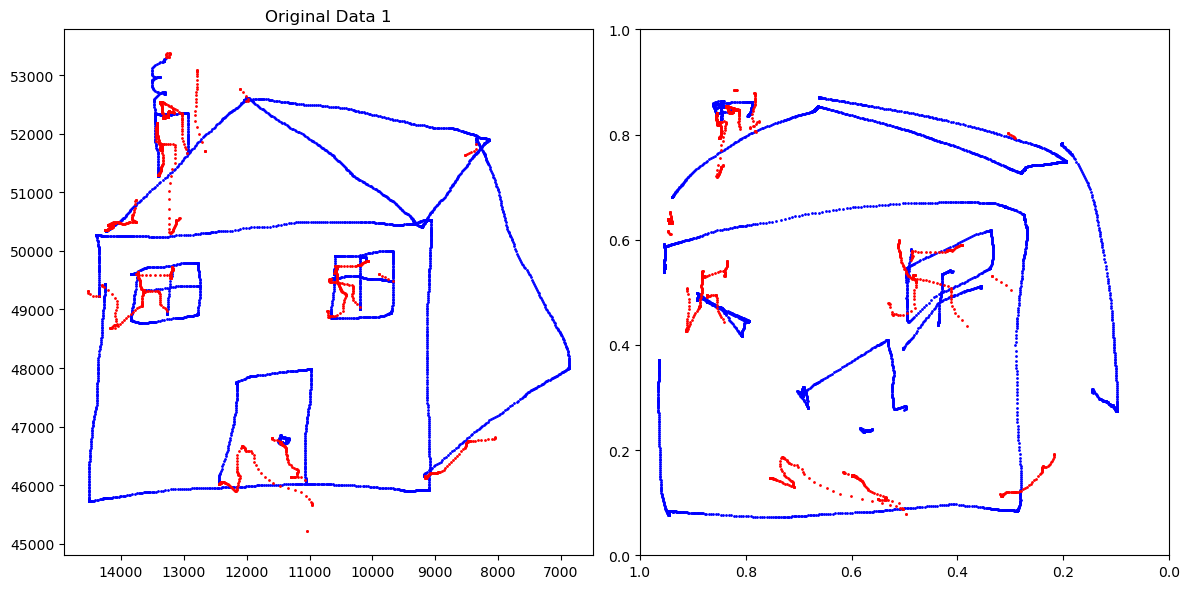

VAE model saved for epoch 100 at vae_models\epoch_100_model.h5.
Final VAE model saved.


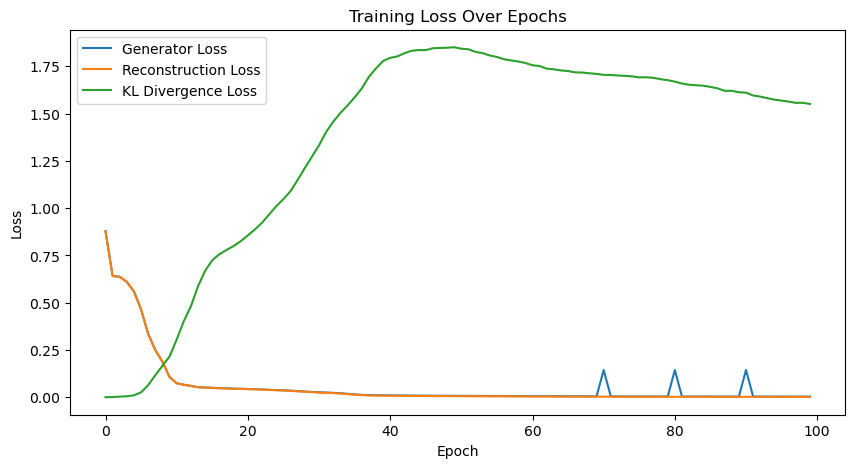

<Figure size 640x480 with 0 Axes>

In [64]:
#Cell 8
@tf.function
def train_vae_step(model, x, optimizer, lstm_discriminator=None):
    with tf.GradientTape() as tape:
        x_reconstructed, mean, logvar = model(x)
        reconstruction_loss, kl_loss, total_kl_loss = compute_loss(model, x)
        
        if lstm_discriminator is not None:
            real_predictions = lstm_discriminator(tf.expand_dims(x, axis=0))
            fake_predictions = lstm_discriminator(tf.expand_dims(x_reconstructed, axis=0))
            discriminator_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions) +
                                                tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_predictions), fake_predictions))
            generator_loss = reconstruction_loss + 0.001 * total_kl_loss + 0.1 * discriminator_loss
        else:
            generator_loss = reconstruction_loss + 0.001 * total_kl_loss
    
    gradients = tape.gradient(generator_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return generator_loss, reconstruction_loss, kl_loss

@tf.function
def train_lstm_step(lstm_model, real_data, generated_data, optimizer):
    with tf.GradientTape() as tape:
        real_predictions = lstm_model(real_data)
        generated_predictions = lstm_model(generated_data)
        real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions)
        generated_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(generated_predictions), generated_predictions)
        total_loss = real_loss + generated_loss
    gradients = tape.gradient(total_loss, lstm_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, lstm_model.trainable_variables))
    return total_loss

# Initialize LSTM discriminator and optimizer
lstm_discriminator = LSTMDiscriminator()
lstm_optimizer = tf.keras.optimizers.Adam(learning_rate)

batch_size = 1024
train_datasets = [tf.data.Dataset.from_tensor_slices(data).shuffle(10000).batch(batch_size) for data in processed_data]

# Set up alternating epochs
vae_epochs = 70
lstm_interval = 10
epochs = 100
visual_per_num_epoch = 20
num_augmented_files = 7

generator_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []
nrmse_history = []

save_dir = "vae_models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for epoch in range(epochs):
    generator_loss = 0 
    reconstruction_loss_sum = 0
    kl_loss_sum = 0
    num_batches = sum(len(dataset) for dataset in train_datasets)

    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for dataset in train_datasets:
            for batch in dataset:
                use_lstm = epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0
                generator_loss_batch, reconstruction_loss, kl_loss = train_vae_step(vae, batch, optimizer, lstm_discriminator if use_lstm else None)
                generator_loss += generator_loss_batch
                reconstruction_loss_sum += reconstruction_loss
                kl_loss_sum += kl_loss
                pbar.update(1)
                pbar.set_postfix({'Generator Loss': float(generator_loss_batch), 'Reconstruction Loss': float(reconstruction_loss), 'KL Loss': float(kl_loss)})

    # Train LSTM every `lstm_interval` epochs after `vae_epochs`
    if epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0:
        for data in processed_data:
            augmented_data = vae.decode(tf.random.normal(shape=(data.shape[0], latent_dim))).numpy()
            real_data = tf.expand_dims(data, axis=0)
            generated_data = tf.expand_dims(augmented_data, axis=0)
            lstm_loss = train_lstm_step(lstm_discriminator, real_data, generated_data, lstm_optimizer)
        print(f'LSTM training at epoch {epoch+1}: Discriminator Loss = {lstm_loss.numpy()}')


    avg_generator_loss = generator_loss / num_batches  # Update the average calculation
    avg_reconstruction_loss = reconstruction_loss_sum / num_batches
    avg_kl_loss = kl_loss_sum / num_batches

    generator_loss_history.append(avg_generator_loss)  # Update history list
    reconstruction_loss_history.append(avg_reconstruction_loss)
    kl_loss_history.append(avg_kl_loss)



    print(f"Epoch {epoch+1}: Generator Loss = {avg_generator_loss:.6f}, Reconstruction Loss = {avg_reconstruction_loss:.6f}, KL Divergence Loss = {avg_kl_loss:.6f}")



    # Cell 5 (visualization part)
    if (epoch + 1) % visual_per_num_epoch == 0:
        base_latent_variability = 100.0
        latent_variability_range = (0.1, 5.0)

        augmented_datasets = generate_augmented_data(vae, num_augmented_files, avg_data_points, processed_data, 
                                                     base_latent_variability, latent_variability_range)

        # Calculate actual latent variabilities and lengths used
        latent_variabilities = [base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1]) for _ in range(num_augmented_files)]
        augmented_lengths = [len(data) for data in augmented_datasets]

        fig, axs = plt.subplots(1, num_augmented_files + len(original_data_frames), figsize=(6*(num_augmented_files + len(original_data_frames)), 6))

        for i, original_data in enumerate(original_data_frames):
            original_on_paper = original_data[original_data['pen_status'] == 1]
            original_in_air = original_data[original_data['pen_status'] == 0]

            axs[i].scatter(original_on_paper['y'], original_on_paper['x'], c='b', s=1, label='On Paper')
            axs[i].scatter(original_in_air['y'], original_in_air['x'], c='r', s=1, label='In Air')
            axs[i].set_title(f'Original Data {i+1}')
            axs[i].invert_xaxis()

        # Set consistent axis limits for square aspect ratio for both original and augmented data
        x_min = min(data[:, 0].min() for data in processed_data)
        x_max = max(data[:, 0].max() for data in processed_data)
        y_min = min(data[:, 1].min() for data in processed_data)
        y_max = max(data[:, 1].max() for data in processed_data)

        for i, (augmented_data, latent_var, length) in enumerate(zip(augmented_datasets, latent_variabilities, augmented_lengths)):
            augmented_on_paper = augmented_data[augmented_data[:, 3] == 1]
            augmented_in_air = augmented_data[augmented_data[:, 3] == 0]

            axs[i+len(original_data_frames)].scatter(augmented_on_paper[:, 1], augmented_on_paper[:, 0], c='b', s=1, label='On Paper')
            axs[i+len(original_data_frames)].scatter(augmented_in_air[:, 1], augmented_in_air[:, 0], c='r', s=1, label='In Air')
            axs[i+len(original_data_frames)].invert_xaxis()
            axs[i+len(original_data_frames)].set_xlim(y_max, y_min)
            axs[i+len(original_data_frames)].set_ylim(x_min, x_max)

        plt.tight_layout()
        plt.show()
        # Save VAE model after each epoch, directly into the `vae_models` folder
        model_save_path = os.path.join(save_dir, f"epoch_{epoch+1}_model.h5")
        vae.save(model_save_path)
        print(f"VAE model saved for epoch {epoch+1} at {model_save_path}.")

# Final output and plots
plt.ioff()
plt.show()

vae.save('pentab_saved_model.h5')
print("Final VAE model saved.")

# Plot generator loss history
plt.figure(figsize=(10, 5))
plt.plot(generator_loss_history, label='Generator Loss')  # Update label
plt.plot(reconstruction_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pretrained VAE model loaded.
Starting augmentation iteration 1
Augmented data saved to augmented_data\synthetic_u00001s00001_hw00002(3).svc
Augmented data saved to augmented_data_nested\u00001s00001_hw00002.svc
Shape of augmented data for u00001s00001_hw00002.svc: (5549, 7)
Completed augmentation iteration 1
Starting augmentation iteration 2


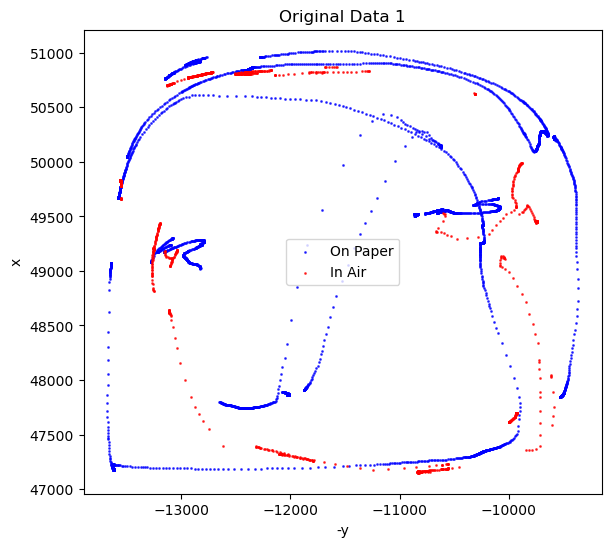

Augmented data saved to augmented_data\synthetic_u00001s00001_hw00002(4).svc
Augmented data saved to augmented_data_nested\u00001s00001_hw00002.svc
Shape of augmented data for u00001s00001_hw00002.svc: (5548, 7)
Completed augmentation iteration 2
Starting augmentation iteration 3


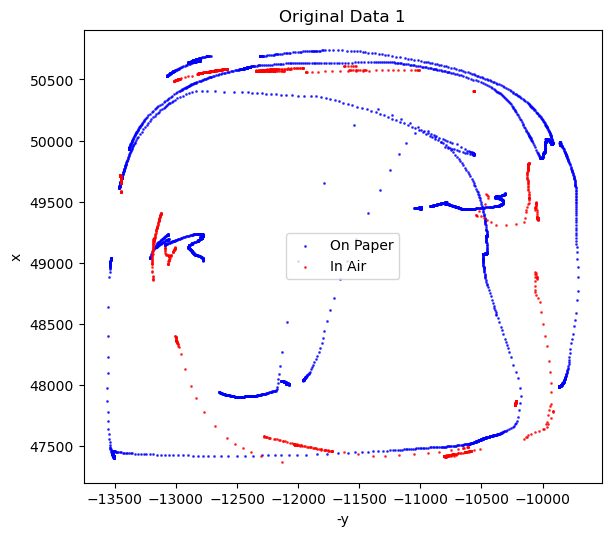

Augmented data saved to augmented_data\synthetic_u00001s00001_hw00002(5).svc
Augmented data saved to augmented_data_nested\u00001s00001_hw00002.svc
Shape of augmented data for u00001s00001_hw00002.svc: (5547, 7)
Completed augmentation iteration 3
Cleared augmented_data_nested directory after the final iteration.
Nested augmentation process completed.


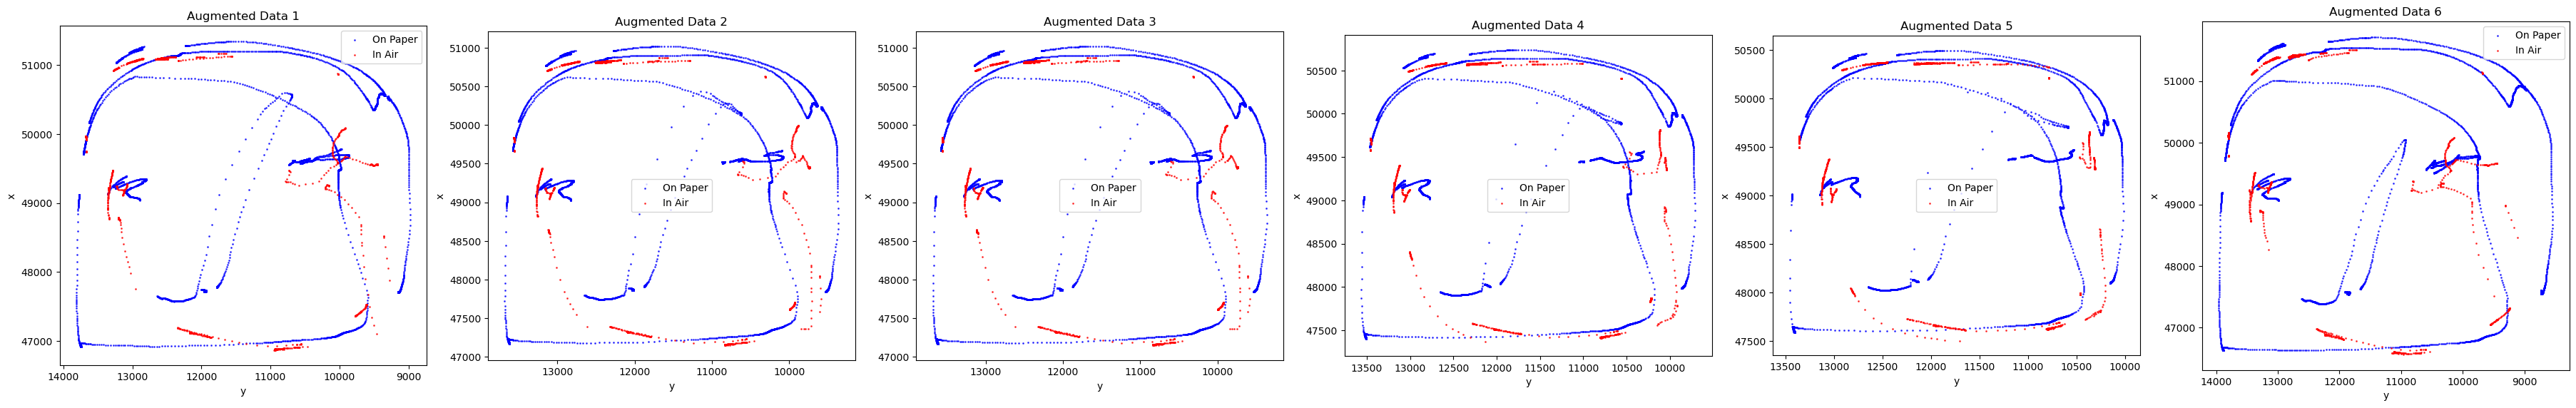

In [52]:
# Cell 9
import shutil

# Base latent variability settings
base_latent_variability = 100.0
latent_variability_range = (0.99, 1.01)
all_augmented_data = []  # Global list to store all augmented data

def repeat_backwards(original_paa, augmented_length):
    repeat_count = augmented_length - len(original_paa)
    if repeat_count <= 0:
        return original_paa
    backwards_rows = np.empty((0, original_paa.shape[1]))
    for i in range(repeat_count):
        row_to_repeat = original_paa[-(i % len(original_paa) + 1)]
        backwards_rows = np.vstack((backwards_rows, row_to_repeat))
    return np.vstack((original_paa, backwards_rows))

def visualize_augmented_data_from_directory(directory):
    augmented_files = [f for f in os.listdir(directory) if f.startswith('synthetic_') and f.endswith('.svc')]
    num_files = len(augmented_files)
    if num_files == 0:
        print("No augmented data files found in the directory.")
        return
    
    fig, axs = plt.subplots(1, num_files, figsize=(6 * num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]
    
    for i, filename in enumerate(augmented_files):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, delim_whitespace=True, header=None)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]

        axs[i].scatter(on_paper['y'], on_paper['x'], c='b', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(in_air['y'], in_air['x'], c='r', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Augmented Data {i + 1}')
        axs[i].set_xlabel('y')
        axs[i].set_ylabel('x')
        axs[i].invert_xaxis()
        axs[i].set_aspect('equal')
        axs[i].legend()
    
    plt.show()

def get_unique_filename(directory, filename):
    base, extension = os.path.splitext(filename)
    counter = 1
    while os.path.exists(os.path.join(directory, filename)):
        filename = f"{base}({counter}){extension}"
        counter += 1
    return filename

def download_augmented_data_with_modified_timestamp(augmented_datasets, scalers, original_data_frames, original_filenames, directory1='augmented_data', directory2='augmented_data_nested'):
    global all_augmented_data  # Access the global list

    if not os.path.exists(directory1):
        os.makedirs(directory1)
    
    if not os.path.exists(directory2):
        os.makedirs(directory2)

    for i, (augmented_data, scaler, original_df, original_filename) in enumerate(zip(augmented_datasets, scalers, original_data_frames, original_filenames)):
        augmented_xyz = scaler.inverse_transform(augmented_data[:, :3])
        augmented_xyz_int = np.rint(augmented_xyz).astype(int)
        pen_status = augmented_data[:, 3].astype(int)
        original_paa = original_df[['pressure', 'azimuth', 'altitude']].values
        
        if len(augmented_data) > len(original_paa):
            original_paa = repeat_backwards(original_paa, len(augmented_data))
        
        original_paa_int = np.rint(original_paa).astype(int)
        
        new_timestamps = np.zeros(len(augmented_data), dtype=int)
        increment_sequence = [7, 8]
        current_time = 0
        for idx in range(len(augmented_data)):
            new_timestamps[idx] = current_time
            current_time += increment_sequence[idx % 2]

        augmented_xyz_int[:, 2] = new_timestamps

        augmented_data_original_scale = np.column_stack((
            augmented_xyz_int,
            pen_status,
            original_paa_int[:len(augmented_data)]
        ))

        # Use the original filename for nested directory
        nested_filename = original_filename
        nested_file_path = os.path.join(directory2, nested_filename)

        # For augmented_data directory, add 'synthetic_' prefix and handle duplicates
        augmented_filename = f"synthetic_{original_filename}"
        augmented_filename = get_unique_filename(directory1, augmented_filename)
        augmented_file_path = os.path.join(directory1, augmented_filename)

        np.savetxt(augmented_file_path, augmented_data_original_scale, fmt='%d', delimiter=' ')
        np.savetxt(nested_file_path, augmented_data_original_scale, fmt='%d', delimiter=' ')

        # Only store augmented data from the augmented_data directory
        all_augmented_data.append(augmented_data_original_scale)

        print(f"Augmented data saved to {augmented_file_path}")
        print(f"Augmented data saved to {nested_file_path}")
        print(f"Shape of augmented data for {original_filename}: {augmented_data_original_scale.shape}")

def nested_augmentation(num_augmentations, num_files_to_use):
    with custom_object_scope({'VAE': VAE}):
        vae_pretrained = load_model('vae_models/epoch_100_model.h5')
    print("Pretrained VAE model loaded.")

    # Use the existing data for the first iteration
    global data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames

    for iteration in range(num_augmentations):
        print(f"Starting augmentation iteration {iteration + 1}")
        
        if iteration > 0:
            # Only update the data for subsequent iterations
            directory = 'augmented_data_nested'
            data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames = upload_and_process_files(directory, num_files_to_use)
        
        augmented_datasets = generate_augmented_data(vae_pretrained, num_files_to_use, avg_data_points, processed_data, 
                                                     base_latent_variability, latent_variability_range)
        
        # Clear augmented_data_nested directory
        if os.path.exists('augmented_data_nested'):
            shutil.rmtree('augmented_data_nested')
        os.makedirs('augmented_data_nested')
        
        download_augmented_data_with_modified_timestamp(augmented_datasets, scalers, original_data_frames, input_filenames)
        
        print(f"Completed augmentation iteration {iteration + 1}")
    
    # Clear augmented_data_nested directory after the last iteration
    if os.path.exists('augmented_data_nested'):
        shutil.rmtree('augmented_data_nested')
        print("Cleared augmented_data_nested directory after the final iteration.")
    
    print("Nested augmentation process completed.")
    visualize_augmented_data_from_directory('augmented_data')
    

# Set the number of augmentations and files to use
num_augmentations = 3  # Change this to control the number of nested augmentations

# Run the nested augmentation process
nested_augmentation(num_augmentations, num_files_to_use)

In [53]:
# Cell 11 NRMSE
from glob import glob
import re

def read_svc_file(file_path):
    return pd.read_csv(file_path, sep=' ', header=None, 
                       names=['x', 'y', 'timestamp', 'pen_status'])

def calculate_nrmse(original, predicted):
    if original.shape != predicted.shape:
        raise ValueError("The shapes of the original and predicted datasets must match.")
    mse = np.mean((original - predicted) ** 2)
    rmse = np.sqrt(mse)
    nrmse = rmse / (np.max(original) - np.min(original))
    return nrmse

def get_matching_augmented_files(original_file, augmented_folder):
    base_name = os.path.basename(original_file)
    base_name_without_ext = os.path.splitext(base_name)[0]
    pattern = os.path.join(augmented_folder, f"synthetic_{base_name_without_ext}*.svc")
    matching_files = glob(pattern)
    
    # Sort files based on the number in parentheses, with the base file (no number) first
    def sort_key(filename):
        match = re.search(r'\((\d+)\)', filename)
        return int(match.group(1)) if match else -1
    
    return sorted(matching_files, key=sort_key)

def process_files(imputed_folder, augmented_folder, input_filenames):
    nrmse_results = {}

    # Create a set of base filenames (without extensions) for easy comparison
    input_filenames_set = {os.path.splitext(os.path.basename(filename))[0] for filename in input_filenames}

    for original_file in glob(os.path.join(imputed_folder, "*.svc")):
        base_name = os.path.splitext(os.path.basename(original_file))[0]
        
        # Only process files that are present in input_filenames
        if base_name not in input_filenames_set:
            continue
        
        file_name = os.path.basename(original_file)
        original_data = read_svc_file(original_file)
        
        matching_augmented_files = get_matching_augmented_files(original_file, augmented_folder)
        
        file_nrmse = []
        for augmented_file in matching_augmented_files:
            augmented_data = read_svc_file(augmented_file)
            
            # Trim to the shorter length
            min_length = min(len(original_data), len(augmented_data))
            original_array = original_data.iloc[:min_length].values
            augmented_array = augmented_data.iloc[:min_length].values
            
            nrmse = calculate_nrmse(original_array, augmented_array)
            file_nrmse.append(nrmse)
        
        nrmse_results[file_name] = file_nrmse

    return nrmse_results

# Define the folders directly in the notebook cell
imputed_folder = "original_absolute"
augmented_folder = "augmented_data"

# Process the files and calculate NRMSE
results = process_files(imputed_folder, augmented_folder, input_filenames)

# Display the results
for original_file, nrmse_values in results.items():
    print(f"Results for {original_file}:")
    for i, nrmse in enumerate(nrmse_values):
        augmented_version = f"({i})" if i > 0 else "base"
        print(f"  NRMSE for augmented version {augmented_version}: {nrmse:.4f}")
    
    if nrmse_values:
        avg_nrmse = np.mean(nrmse_values)
        print(f"  Average NRMSE: {avg_nrmse:.4f}")
    print()

# Calculate and display the overall average NRMSE
all_nrmse = [nrmse for nrmse_list in results.values() for nrmse in nrmse_list]
overall_avg_nrmse = np.mean(all_nrmse)
print(f"Overall Average NRMSE: {overall_avg_nrmse:.4f}")

Results for u00001s00001_hw00002.svc:
  NRMSE for augmented version base: 0.0085
  NRMSE for augmented version (1): 0.0105
  NRMSE for augmented version (2): 0.0136
  NRMSE for augmented version (3): 0.0136
  NRMSE for augmented version (4): 0.0150
  NRMSE for augmented version (5): 0.0174
  Average NRMSE: 0.0131

Overall Average NRMSE: 0.0131


In [54]:
# Cell 12 Post-Hoc Discriminative Score
def process_files(imputed_folder, augmented_folder, input_filenames):
    all_real_data = []
    all_synthetic_data = []

    # Create a set of base filenames (without extensions) for easy comparison
    input_filenames_set = {os.path.splitext(os.path.basename(filename))[0] for filename in input_filenames}

    for original_file in glob(os.path.join(imputed_folder, "*.svc")):
        base_name = os.path.splitext(os.path.basename(original_file))[0]
        
        # Only process files that are present in input_filenames
        if base_name not in input_filenames_set:
            continue
        
        original_data = read_svc_file(original_file)
        all_real_data.append(original_data.values)
        
        matching_augmented_files = get_matching_augmented_files(original_file, augmented_folder)
        
        for augmented_file in matching_augmented_files:
            augmented_data = read_svc_file(augmented_file)
            all_synthetic_data.append(augmented_data.values)

    return np.concatenate(all_real_data), np.concatenate(all_synthetic_data)

def create_lstm_classifier(input_shape):
    model = Sequential([
        LSTM(16, input_shape=input_shape, return_sequences=True),
        LSTM(8),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def prepare_data_for_lstm(real_data, synthetic_data):
    n_features = min(real_data.shape[1], synthetic_data.shape[1])
    real_data_trimmed = real_data[:, :n_features]
    synthetic_data_trimmed = synthetic_data[:, :n_features]
    
    X = np.vstack((real_data_trimmed, synthetic_data_trimmed))
    y = np.concatenate((np.ones(len(real_data)), np.zeros(len(synthetic_data))))
    return X, y

def post_hoc_discriminative_score(real_data, synthetic_data, n_splits=10):
    X, y = prepare_data_for_lstm(real_data, synthetic_data)
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []
    
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold + 1}/{n_splits}:")  # New print statement for fold numbers
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

        model = create_lstm_classifier((1, X_train.shape[2]))
        
        # Train model and show epoch progress for this fold
        history = model.fit(X_train, y_train, epochs=2, batch_size=1024, verbose=1)

        y_pred = (model.predict(X_test) > 0.5).astype(int)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    return mean_accuracy, std_accuracy

# Specify your folders
imputed_folder = "original_absolute"
augmented_folder = "augmented_data"

# Process files, without NRMSE
real_data, synthetic_data = process_files(imputed_folder, augmented_folder, input_filenames)

# Compute post-hoc discriminative score
mean_accuracy, std_accuracy = post_hoc_discriminative_score(real_data, synthetic_data)

print(f"Mean accuracy: {mean_accuracy:.4f} (±{std_accuracy:.4f})")


Fold 1/10:


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8584 - loss: 0.6279
Epoch 2/2
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8576 - loss: 0.5801
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

Fold 2/10:


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.8584 - loss: 0.6747
Epoch 2/2
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8570 - loss: 0.6155
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

Fold 3/10:
Epoch 1/2


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8181 - loss: 0.6436
Epoch 2/2
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8573 - loss: 0.5500
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

Fold 4/10:
Epoch 1/2


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8565 - loss: 0.6537
Epoch 2/2
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8559 - loss: 0.5846
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

Fold 5/10:


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.3664 - loss: 0.7034
Epoch 2/2
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8571 - loss: 0.5968
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

Fold 6/10:
Epoch 1/2


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.5509 - loss: 0.6845
Epoch 2/2
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8598 - loss: 0.6236
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

Fold 7/10:


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8256 - loss: 0.6607
Epoch 2/2
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8578 - loss: 0.5799
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

Fold 8/10:


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.4035 - loss: 0.6965
Epoch 2/2
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8564 - loss: 0.6269
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step

Fold 9/10:


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2


SystemError: \objects\listobject.c:338: bad argument to internal function

In [55]:
# Cell 13 Post Hoc Predictive Score
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold
from keras.callbacks import Callback
from tqdm import tqdm

# Step 1: Prepare Data
def prepare_data(df, time_steps=5):
    data = df[['x', 'y']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)
    
    # Create sequences of length `time_steps`
    X, y = [], []
    for i in range(len(data_scaled) - time_steps):
        X.append(data_scaled[i:i+time_steps])
        y.append(data_scaled[i+time_steps])
    
    return np.array(X), np.array(y), scaler

# Example usage
X, y, scaler = prepare_data(data_frames[0])

# Custom callback for progress bar
class CustomCallback(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.progress_bar = tqdm(total=self.epochs, desc="Training Progress")

    def on_epoch_end(self, epoch, logs=None):
        self.progress_bar.update(1)

    def on_train_end(self, logs=None):
        self.progress_bar.close()

# Step 2: Define the LSTM Model
def create_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))  # Adding dropout to introduce randomness
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(2))  # Predict x and y
    model.compile(optimizer='adam', loss='mse')
    return model

# Step 3: Evaluate Model Function
def evaluate_model(model, X_test, y_test, scaler):
    # Predict and inverse transform
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test)
    
    # Compute MAPE for each test sample
    mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
    print(f"\nMAPE: {mape * 100:.2f}%")
    
    # Interpretation of MAPE
    if mape < 0.1:
        interpretation = "Excellent prediction"
    elif mape < 0.2:
        interpretation = "Good prediction"
    elif mape < 0.5:
        interpretation = "Fair prediction"
    else:
        interpretation = "Poor prediction"
    
    print(f"Interpretation: {interpretation}")
    
    return mape

# Step 4: K-Fold Cross-Validation Implementation
kf = KFold(n_splits=10, shuffle=True, random_state=np.random.randint(1000))  # 10-fold cross-validation

mape_values = []
for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
    print(f"\n--- Fold {fold} ---")
    
    # Split data into training and testing sets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_model((X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=5, batch_size=512, verbose=3, callbacks=[CustomCallback()])
    
    # Evaluate the model and store MAPE
    mape = evaluate_model(model, X_test, y_test, scaler)
    print(f"Fold {fold} MAPE: {mape * 100:.2f}%")  # Print MAPE for the current fold
    mape_values.append(mape)

# Step 5: Calculate Mean and Standard Deviation of MAPE
mean_mape = np.mean(mape_values)
std_mape = np.std(mape_values)

print(f"\nMean MAPE: {mean_mape * 100:.2f}%")
print(f"Standard Deviation of MAPE: {std_mape * 100:.2f}%")


--- Fold 1 ---


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5


Training Progress:  20%|██        | 1/5 [00:19<01:16, 19.09s/it]

Epoch 2/5


Training Progress:  40%|████      | 2/5 [00:20<00:26,  8.93s/it]

Epoch 3/5


Training Progress:  60%|██████    | 3/5 [00:23<00:11,  5.94s/it]

Epoch 4/5


Training Progress:  80%|████████  | 4/5 [00:25<00:04,  4.56s/it]

Epoch 5/5


Training Progress: 100%|██████████| 5/5 [00:27<00:00,  5.57s/it]


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step

MAPE: 1.06%
Interpretation: Excellent prediction
Fold 1 MAPE: 1.06%

--- Fold 2 ---


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5


Training Progress:  20%|██        | 1/5 [00:15<01:02, 15.73s/it]

Epoch 2/5


Training Progress:  40%|████      | 2/5 [00:17<00:22,  7.64s/it]

Epoch 3/5


Training Progress:  60%|██████    | 3/5 [00:22<00:12,  6.15s/it]

Epoch 4/5


Training Progress:  80%|████████  | 4/5 [00:25<00:05,  5.15s/it]

Epoch 5/5


Training Progress: 100%|██████████| 5/5 [00:29<00:00,  5.85s/it]


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step

MAPE: 1.15%
Interpretation: Excellent prediction
Fold 2 MAPE: 1.15%

--- Fold 3 ---


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5


Training Progress:  20%|██        | 1/5 [00:23<01:35, 23.84s/it]

Epoch 2/5


Training Progress:  40%|████      | 2/5 [00:28<00:37, 12.36s/it]

Epoch 3/5


Training Progress:  60%|██████    | 3/5 [00:32<00:17,  8.66s/it]

Epoch 4/5


Training Progress:  80%|████████  | 4/5 [00:37<00:07,  7.32s/it]

Epoch 5/5


Training Progress: 100%|██████████| 5/5 [00:42<00:00,  8.41s/it]


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step

MAPE: 0.95%
Interpretation: Excellent prediction
Fold 3 MAPE: 0.95%

--- Fold 4 ---


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5


Training Progress:  20%|██        | 1/5 [00:12<00:51, 12.93s/it]

Epoch 2/5


Training Progress:  40%|████      | 2/5 [00:14<00:19,  6.39s/it]

Epoch 3/5


Training Progress:  60%|██████    | 3/5 [00:15<00:08,  4.02s/it]

Epoch 4/5


Training Progress:  80%|████████  | 4/5 [00:17<00:03,  3.15s/it]

Epoch 5/5


Training Progress: 100%|██████████| 5/5 [00:18<00:00,  3.78s/it]


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step

MAPE: 1.12%
Interpretation: Excellent prediction
Fold 4 MAPE: 1.12%

--- Fold 5 ---


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5


Training Progress:  20%|██        | 1/5 [00:08<00:35,  8.89s/it]

Epoch 2/5


Training Progress:  40%|████      | 2/5 [00:10<00:13,  4.51s/it]

Epoch 3/5


Training Progress:  60%|██████    | 3/5 [00:11<00:06,  3.13s/it]

Epoch 4/5


Training Progress:  80%|████████  | 4/5 [00:13<00:02,  2.46s/it]

Epoch 5/5


Training Progress: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step


KeyboardInterrupt: 